In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anthropic
import json
import tqdm
from sklearn.mixture import GaussianMixture
import os
import pickle

In [ ]:
client = anthropic.Anthropic(api_key='YOUR_API_KEY')

In [24]:

df_raw = pd.read_csv('data/pilot/raw/20_01_2025/tom_dictator_v2_2025-01-20.csv')
                     
# Replace full stop with underscore in df_raw column names
df_raw.columns = df_raw.columns.str.replace('.', '_')

sessions = [
    'tgvqauld',
    'ta176utg'
]

# Only keep rows where session_id is in sessions and where participant_label is not NaN
df_full = df_raw[df_raw['session_code'].isin(sessions) & df_raw['participant_label'].notna() & (df_raw['participant__current_page_name'] == 'End')]
# Insert 
columns = ['participant_code', 'participant_label', 'session_code',
       
       'player_block_type', 'player_block_idx', 'player_idx_in_block', 'player_trust_cond', 'player_trust_label',
       'player_intention', 'player_interest', 
       'player_certainty', 'player_certainty_val', 'player_rigidity', 'player_rigidity_val',
       'player_k_lvl', 'player_trust_predicted', 'player_alpha_prior',
       'player_alpha_prior_entropy', 'player_alpha', 'player_alpha_entropy',
       'player_beta_prior', 'player_beta_prior_entropy', 'player_beta',
       'player_beta_entropy', 'player_beta_social_prior',
       'player_beta_social_prior_entropy', 'player_beta_social',
       'player_beta_social_entropy', 'player_path_taken',
       'player_perceived_certainty_certain',
       'player_perceived_certainty_uncertain',
       'player_perceived_certainty_immutable', 'player_attention',
       'player_attention_passed', 'player_attention_correct',

       'player_focus_work_high', 'player_focus_work_medium', 'player_focus_work_low',
       'player_strategy_high', 'player_strategy_low', 'player_strategy_medium',

       'subsession_round_number',
       'participant__current_app_name',
       'participant__current_page_name', 
       'player_payoff',
]


df = df_full[columns]

# If player is in column name, remove player_ from column name
df.columns = df.columns.str.replace('player_', '')


df_long = df[(df.block_type == 'test')][['participant_code', 'intention', 'certainty', 'rigidity', 'intention', 'trust_cond', 'path_taken']]

df_long['absent'] = df_long.trust_cond.map(lambda x: x == 'none')

# Get dummies for path taken and concat with df_long
path_taken_dummies = pd.get_dummies(df_long['path_taken'], prefix='', prefix_sep='')
df_long = pd.concat([df_long, path_taken_dummies], axis=1)

df_long['delivered'] = df_long['A'] + df_long['B'] > 0
df_long['path_hidden'] = df_long['B'] + df_long['C'] > 0

# Create path_idx column
path_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
}
df['path_idx'] = df['path_taken'].map(lambda x: path_dict[x])
df_long['path_length'] = df_long['path_taken'].map(lambda x: path_dict[x])

# Create certainty_lvl column
certainties_dict = {
    'uncertain': 1,
    'certain': 2,
    'immutable': 3,
}
df_long['certainty_lvl'] = df_long['certainty'].map(lambda x: certainties_dict[x])
df['certainty_lvl'] = df['certainty'].map(lambda x: certainties_dict[x])

# Create trust_lvl column
trust_dict = {
    'none': 4,
    'low': 1,
    'medium': 2,
    'high': 3,
}
df_long['trust_lvl'] = df_long['trust_cond'].map(lambda x: trust_dict[x])
df['trust_lvl'] = df['trust_cond'].map(lambda x: trust_dict[x])

# Assign unique integer to each participant and make sure it is the same for both df and df_long and recoverable
df_long['part_idx'] = pd.Categorical(df_long['participant_code']).codes
df['part_idx'] = pd.Categorical(df['participant_code']).codes



paths_colors = {
    'A': np.array([238, 154, 86])/255,
    'B': np.array([183, 117, 63])/255,
    'C': np.array([50, 114, 169])/255,
    'D': np.array([88, 182, 225])/255,
}

paths_colors_next = {
    'A': np.array([183, 117, 63])/255,
    'B': np.array([50, 114, 169])/255,
    'C': np.array([88, 182, 225])/255,
}

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_56728/2952042552.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path_idx'] = df['path_taken'].map(lambda x: path_dict[x])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_56728/2952042552.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certainty_lvl'] = df['certainty'].map(lambda x: certainties_dict[x])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_56728/2952042552.py:84: SettingWithCopyWarning: 
A value is 

In [25]:
df_demo_raw = pd.read_csv("data/pilot/raw/20_01_2025/generic_demographics_2025-01-20.csv")

df_demo_raw.columns = df_demo_raw.columns.str.replace('.', '_')

sessions = [
    'tgvqauld',
    'ta176utg'
]

df_demo = df_demo_raw[df_demo_raw['session_code'].isin(sessions) & df_demo_raw.participant_label.notna()]
df_demo.columns = df_demo.columns.str.replace('player_', '')

df_demo['part_idx'] = pd.Categorical(df_demo['participant_code']).codes

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_56728/713800357.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['part_idx'] = pd.Categorical(df_demo['participant_code']).codes


In [26]:
variants = [
    'heuristic_test',
    'basic_nodelta',
    'basic_full',
    #'onlyalpha',
    #'nobeta'
    #'fullexp',
    #'nobetaexp',
    #'nodeltaexp'   
]

# Load data
variants_df_params_full = {}
variants_df_params = {}
variants_df_Ys = {}
variants_df_Ys_nobeta = {}
variants_fit = {}
for variant in variants:
    df_params_full = pd.read_csv(f'stan_files/tom_model_{variant}_params.csv')
    variants_df_params[variant] = df_params_full

    df_params = df_params_full.groupby(['part_idx', 'participant_code', 'weight', 'param_code', 'param_name']).value.mean().reset_index()
    variants_df_params[variant] = df_params
    
    df_Ys = pd.read_csv(f'stan_files/tom_model_{variant}_y_sim.csv')
    variants_df_Ys[variant] = df_Ys

    #df_Ys_nobeta = pd.read_csv(f'stan_files/tom_model_basic_{variant}_y_nobeta_sim.csv')
    #variants_df_Ys_nobeta[variant] = df_Ys_nobeta

    # if 'stan_files/tom_model_basic_{variant}_fit.pkl' exists then load it
    if os.path.exists(f'stan_files/tom_model_{variant}_fit.pkl'):
        with open(f'stan_files/tom_model_{variant}_fit.pkl', 'rb') as f:
            fit = pickle.load(f)
        variants_fit[variant] = fit
    else:
        variants_fit[variant] = None


    # Add prediction as heuristic model: actions from features, naively

#df_heuristic = pd.read_csv('data/simulations/heuristic_mixed_model_preds.csv')
#df_heuristic['path_idx_sim'] = 5 - df_heuristic['preds'].round().astype(int)
#df_heuristic['path_taken_sim'] = df_heuristic['path_idx_sim'].map({1: 'A', 2: 'B', 3: 'C', 4: 'D'})
#df_heuristic = df_heuristic.drop(columns=['Unnamed: 0'])
#
## Add heuristic to variants_df_Ys
#variants_df_Ys['heuristic'] = df_heuristic
#variants.append('heuristic')

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_56728/3645497354.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = df['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_56728/3645497354.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['cluster'] = df_demo['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)


Cluster sizes: 
 cluster
0    49
1    50
Name: part_idx, dtype: int64
Cluster means: 
 [[ 0.36979028  0.28909025  4.3478767   4.17414668 11.05811244  4.91777298]
 [ 0.44277959  0.2473035   2.31071274  9.0560295  23.97873976 10.7544003 ]]


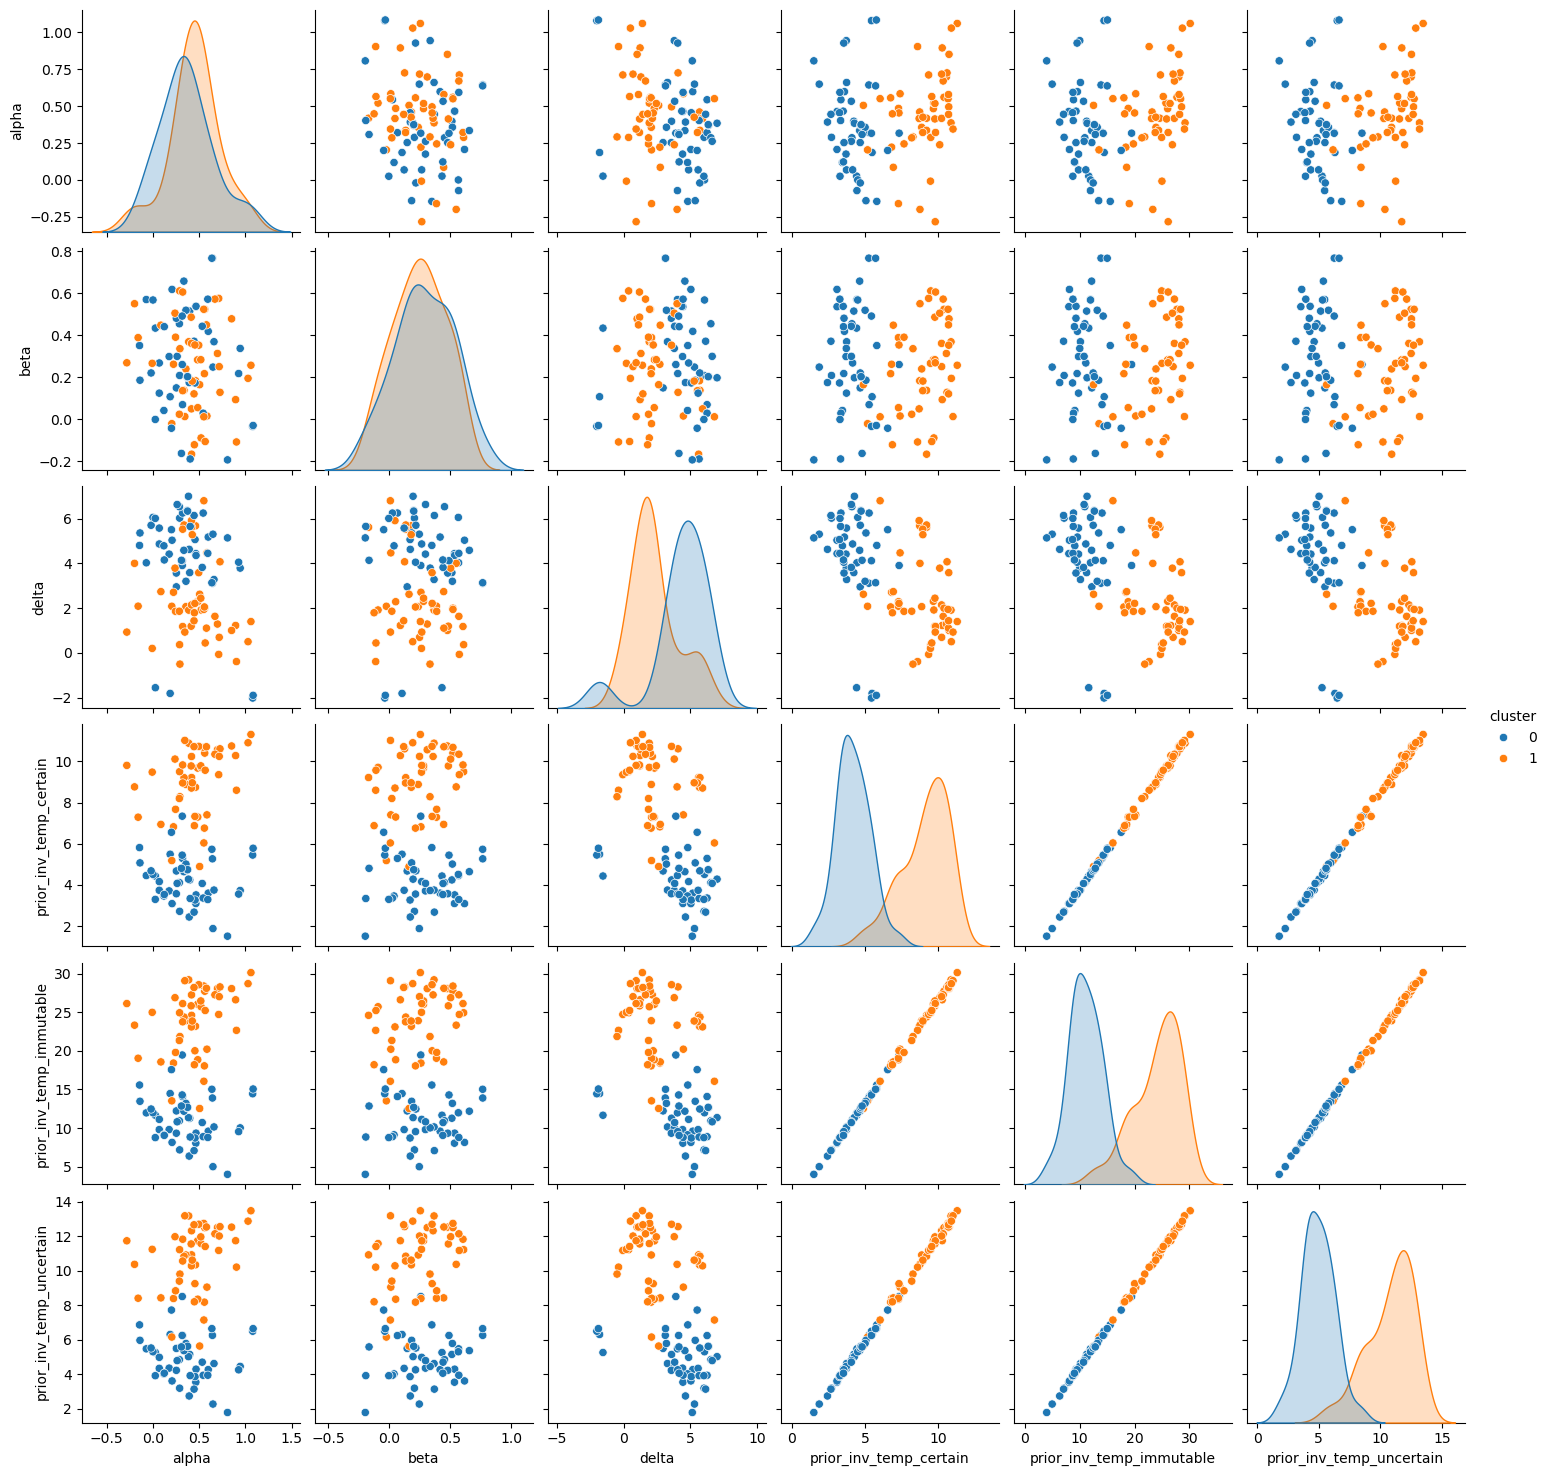

In [27]:
df_params = variants_df_params['basic_full']
df_param_names = df_params[['part_idx', 'param_name', 'value']]
# Unmelt so that each value of param_name is a column
df_param_p = df_param_names.pivot(columns='param_name', index='part_idx', values='value')

gm = GaussianMixture(n_components=2, random_state=0)
gm_fit = gm.fit(df_param_p)

gm.means_

df_param_p['cluster'] = gm.predict(df_param_p)
part_cluster_1 = df_param_p[df_param_p['cluster'] == 0].index
part_cluster_2 = df_param_p[df_param_p['cluster'] == 1].index

for k, df_params in variants_df_params.items():
    df_params['cluster'] = df_params['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)

df['cluster'] = df['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)
df_long['cluster'] = df_long['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)
df_demo['cluster'] = df_demo['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)

df_long.to_csv('data/pilot/df_long_test_cluster.csv', index=False)

print('Cluster sizes: \n', df_params.groupby('cluster').part_idx.nunique())
print('Cluster means: \n', gm.means_)

# Plot all pairs of parameters distributions except alpha in df_param_p against each other
sns.pairplot(df_param_p, hue='cluster', diag_kind='kde')
plt.show()

In [66]:
df_strats = df[['part_idx', 'cluster', 'certainty', 'strategy_high', 'strategy_medium', 'strategy_low']]
# Melt such that focus_work is a single column and value is the value of the focus_work as well as strategy and value is the value of the strategy
df_strategies = df_strats.melt(id_vars=['part_idx', 'cluster', 'certainty'], value_vars=['strategy_high', 'strategy_medium', 'strategy_low'], var_name='trust', value_name='strategy')
df_strategies['trust'] = df_strategies['trust'].str.replace('strategy_', '')

df_strategies = df_strategies.dropna()
# Unstack on trust such that each trust level is a column

df_strategies = df_strategies.set_index(['part_idx', 'cluster', 'trust', 'certainty']).unstack(['trust', 'certainty'])
df_strategies.columns = df_strategies.columns.droplevel(0)



In [67]:
df_strategies = df_strats.melt(id_vars=['part_idx', 'cluster', 'certainty'], value_vars=['strategy_high', 'strategy_medium', 'strategy_low'], var_name='trust', value_name='strategy')
df_strategies['trust'] = df_strategies['trust'].str.replace('strategy_', '')
df_strategies = df_strategies.dropna()

df_strategies

part_idx  cluster  certainty   trust  \
3462   96        1        immutable  high     
3474   83        1        certain    high     
3541   48        0        certain    high     
3547   80        0        certain    high     
3567   32        1        certain    high     
3569   9         0        immutable  high     
3577   81        1        immutable  high     
3588   0         0        immutable  high     
3597   56        1        immutable  high     
3601   48        0        immutable  high     
3606   25        1        immutable  high     
3611   55        1        immutable  high     
3618   51        1        immutable  high     
3624   93        1        certain    high     
3626   30        0        immutable  high     
3628   92        0        uncertain  high     
3632   6         0        uncertain  high     
3638   97        1        uncertain  high     
3639   73        1        uncertain  high     
3644   16        0        immutable  high     
3647   82        1        certain    high     
3653   65        1        immutable  high     
3655   12        0        certain    high     
3658   33        1        certain    high     
3664   22        0        uncertain  high     
3666   25        1        uncertain  high     
3668   88        1        immutable  high     
3669   11        1        certain    high     
3670   45        0        immutable  high     
3673   89        0        certain    high     
3675   75        0        uncertain  high     
3676   43        0        certain    high     
3677   52        1        certain    high     
3681   46        1        immutable  high     
3683   10        1        certain    high     
3685   67        1        uncertain  high     
3689   9         0        uncertain  high     
3690   87        1        uncertain  high     
3691   7         1        immutable  high     
3693   61        1        uncertain  high     
3700   36        1        uncertain  high     
3706   1         0        immutable  high     
3711   85        0        uncertain  high     
3715   12        0        uncertain  high     
3716   14        1        certain    high     
3719   91        0        immutable  high     
3720   54        0        certain    high     
3722   42        1        uncertain  high     
3723   74        0        uncertain  high     
3725   72        0        immutable  high     
3728   88        1        certain    high     
3732   40        1        uncertain  high     
3734   79        0        uncertain  high     
3739   63        0        uncertain  high     
3740   37        1        uncertain  high     
3742   20        1        immutable  high     
3748   92        0        immutable  high     
3751   7         1        uncertain  high     
3754   59        1        uncertain  high     
3755   18        0        uncertain  high     
3756   5         0        certain    high     
3758   97        1        immutable  high     
3760   36        1        immutable  high     
3761   78        0        uncertain  high     
3762   96        1        certain    high     
3763   15        0        uncertain  high     
3765   77        1        uncertain  high     
3766   1         0        certain    high     
3769   29        0        certain    high     
3770   49        1        uncertain  high     
3772   23        0        immutable  high     
3773   65        1        uncertain  high     
3778   33        1        uncertain  high     
3780   54        0        immutable  high     
3782   42        1        immutable  high     
3783   74        0        certain    high     
3784   22        0        certain    high     
3785   72        0        uncertain  high     
3787   80        0        uncertain  high     
3789   11        1        immutable  high     
3790   45        0        certain    high     
3791   55        1        certain    high     
3792   40        1        immutable  high     
3793   89        0        immutable  high     
3794   79   

In [68]:


def get_response(system_prompt, message):
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=1000,
        temperature=1,
        system=system_prompt,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": message
                    }
                ]
            }
        ]
    )
    return response

In [72]:


system_prompt = """
You are a cognitive scientist. 
You are given qualitative responses of participants in a study about theory of mind.
The study was assessing whether participants picked actions, i.e. deciding to be late to work in or not by delivering an item, based on whether the other trusted them or not to do them a favour, represented by a face with a certain facial expression (mood), and whether the other was certain or not about this trust, represented by a character color. The sentence below is a response for one pairing of trust and certainty which you do not have access to.
The team believes that participants' report should be rated on three dimensions from 0 to 10:
- How much they cared about being late to work and upsetting their boss (policy)
- How much they cared about the other person's mood/trust
- Whether they considered the certainty of the other person in their decision making process

Each rating should be accompanied by an explanation of the rating.

Your response should follow the following json format, omit the ```json ```:
{
    "boss": {
        "value": 0,
        "explanation": ""
    },
    "trust":{
        "value": 0,
        "explanation": ""
    },
    "certainty": {
        "value": 0,
        "explanation": ""
    }
}

The response is given below:
"""

system_prompt



'\nYou are a cognitive scientist. \nYou are given qualitative responses of participants in a study about theory of mind.\nThe study was assessing whether participants picked actions, i.e. deciding to be late to work in or not by delivering an item, based on whether the other trusted them or not to do them a favour, represented by a face with a certain facial expression (mood), and whether the other was certain or not about this trust, represented by a character color. The sentence below is a response for one pairing of trust and certainty which you do not have access to.\nThe team believes that participants\' report should be rated on three dimensions from 0 to 10:\n- How much they cared about being late to work and upsetting their boss (policy)\n- How much they cared about the other person\'s mood/trust\n- Whether they considered the certainty of the other person in their decision making process\n\nEach rating should be accompanied by an explanation of the rating.\n\nYour response sho

In [73]:
df_strategies.shape

(891, 5)

In [ ]:
df_strats_out = df_strategies.copy()
responses = []
# Iterate over the rows of the dataframe
for index, row in tqdm.tqdm(df_strats_out.iterrows()):

    # Get the graph id
    strategy = row['strategy']

    # For the first graph, use the system prompt
    response = get_response(system_prompt, strategy)

    responses.append(response)

        





891it [1:16:18,  5.14s/it]


In [77]:

responses_unpacked = {
    'boss_value': [],
    'boss_explanation': [],
    'trust_value': [],
    'trust_explanation': [],
    'certainty_value': [],
    'certainty_explanation': [],
}
for response in responses:
    if response.content[0].text[0] == '{':
        # Parse the response
        parsed_response = json.loads(response.content[0].text)
    elif response.content[0].text[0] == '`':
        # Remove the ```json and parse the response
        parsed_response = json.loads(response.content[0].text[7:-3])
    
    
    # Update the dataframe with the response
    responses_unpacked['boss_value'].append(parsed_response['boss']['value'])
    responses_unpacked['boss_explanation'].append(parsed_response['boss']['explanation'])
    responses_unpacked['trust_value'].append(parsed_response['trust']['value'])
    responses_unpacked['trust_explanation'].append(parsed_response['trust']['explanation'])
    responses_unpacked['certainty_value'].append(parsed_response['certainty']['value'])
    responses_unpacked['certainty_explanation'].append(parsed_response['certainty']['explanation'])

In [86]:

df_strats_out = pd.concat([df_strategies, pd.DataFrame(responses_unpacked)], axis=1)

In [94]:
pd.DataFrame(responses_unpacked)

boss_value  \
0    7            
1    7            
2    9            
3    0            
4    7            
5    7            
6    5            
7    3            
8    8            
9    0            
10   0            
11   7            
12   5            
13   7            
14   0            
15   1            
16   8            
17   10           
18   0            
19   6            
20   0            
21   0            
22   8            
23   8            
24   8            
25   5            
26   9            
27   8            
28   2            
29   3            
30   8            
31   6            
32   4            
33   3            
34   5            
35   7            
36   7            
37   8            
38   8            
39   6            
40   0            
41   0            
42   0            
43   8            
44   0            
45   8            
46   7            
47   7            
48   7            
49   3            
50   7            
51   3            
52   0            
53   0            
54   7            
55   8            
56   5            
57   8            
58   0            
59   8            
60   3            
61   8            
62   8            
63   8            
64   0            
65   3            
66   3            
67   7            
68   3            
69   7            
70   7            
71   8            
72   7            
73   7            
74   8            
75   0            
76   7            
77   3            
78   0            
79   7            
80   0            
81   0            
82   0            
83   4            
84   8            
85   3            
86   3            
87   7            
88   7            
89   0            
90   0            
91   0            
92   8            
93   0            
94   2            
95   3            
96   5            
97   0            
98   6            
99   7            
100  7            
101  4            
102  7            
103  3            
104  3            
105  0            
106  8            
107  5            
108  6            
109  8            
110  0            
111  3            
112  0            
113  8            
114  8            
115  2            
116  8            
117  6            
118  8            
119  10           
120  8            
121  10           
122  8            
123  3            
124  6            
125  5            
126  5            
127  3            
128  8            
129  8            
130  0            
131  5            
132  0            
133  0            
134  8            
135  8            
136  10           
137  8            
138  8            
139  8            
140  0            
141  0            
142  1            
143  0            
144  2            
145  0            
146  8            
147  7            
148  8            
149  8            
150  5            
151  0            
152  0            
153  5            
154  3            
155  8            
156  2            
157  7            
158  10           
159  0            
160  0            
161  8            
162  8            
163  8            
164  7            
165  8            
166  3            
167  0            
168  0            
169  0            
170  4            
171  8            
172  7            
173  1            
174  8            
175  5            
176  1            
177  6            
178  7            
179  8            
180  8            
181  3            
182  5            
183  2            
184  7            
185  0            
186  7            
187  0            
188  0            
189  8            
190  7            
191  8            
192  8            
193  3            
194  8            
195  7            
196  5            
197  9            
198  4            
199  1            
200  2            
201  0            
202  2            
203  0            
204  1            
205  3            
206  8            
207  4            
208  9            
209  3         

In [103]:
df_responses = pd.DataFrame(responses_unpacked)
print(df_strategies.shape, df_responses.shape)

df_strats_out = pd.concat([df_strategies.reset_index(drop=True), df_responses.reset_index(drop=True)], axis=1)
df_strats_out

(891, 5) (891, 6)


part_idx  cluster  certainty   trust  \
0    96        1        immutable  high     
1    83        1        certain    high     
2    48        0        certain    high     
3    80        0        certain    high     
4    32        1        certain    high     
5    9         0        immutable  high     
6    81        1        immutable  high     
7    0         0        immutable  high     
8    56        1        immutable  high     
9    48        0        immutable  high     
10   25        1        immutable  high     
11   55        1        immutable  high     
12   51        1        immutable  high     
13   93        1        certain    high     
14   30        0        immutable  high     
15   92        0        uncertain  high     
16   6         0        uncertain  high     
17   97        1        uncertain  high     
18   73        1        uncertain  high     
19   16        0        immutable  high     
20   82        1        certain    high     
21   65        1        immutable  high     
22   12        0        certain    high     
23   33        1        certain    high     
24   22        0        uncertain  high     
25   25        1        uncertain  high     
26   88        1        immutable  high     
27   11        1        certain    high     
28   45        0        immutable  high     
29   89        0        certain    high     
30   75        0        uncertain  high     
31   43        0        certain    high     
32   52        1        certain    high     
33   46        1        immutable  high     
34   10        1        certain    high     
35   67        1        uncertain  high     
36   9         0        uncertain  high     
37   87        1        uncertain  high     
38   7         1        immutable  high     
39   61        1        uncertain  high     
40   36        1        uncertain  high     
41   1         0        immutable  high     
42   85        0        uncertain  high     
43   12        0        uncertain  high     
44   14        1        certain    high     
45   91        0        immutable  high     
46   54        0        certain    high     
47   42        1        uncertain  high     
48   74        0        uncertain  high     
49   72        0        immutable  high     
50   88        1        certain    high     
51   40        1        uncertain  high     
52   79        0        uncertain  high     
53   63        0        uncertain  high     
54   37        1        uncertain  high     
55   20        1        immutable  high     
56   92        0        immutable  high     
57   7         1        uncertain  high     
58   59        1        uncertain  high     
59   18        0        uncertain  high     
60   5         0        certain    high     
61   97        1        immutable  high     
62   36        1        immutable  high     
63   78        0        uncertain  high     
64   96        1        certain    high     
65   15        0        uncertain  high     
66   77        1        uncertain  high     
67   1         0        certain    high     
68   29        0        certain    high     
69   49        1        uncertain  high     
70   23        0        immutable  high     
71   65        1        uncertain  high     
72   33        1        uncertain  high     
73   54        0        immutable  high     
74   42        1        immutable  high     
75   74        0        certain    high     
76   22        0        certain    high     
77   72        0        uncertain  high     
78   80        0        uncertain  high     
79   11        1        immutable  high     
80   45        0        certain    high     
81   55        1        certain    high     
82   40        1        immutable  high     
83   89        0        immutable  high     
84   79        0        certain    high     
85   75        0        immutable  high     
86   43        0        immutable  high     
87   52        1        uncertain  high     


In [107]:
df_strats_out.groupby(['certainty', 'trust', 'cluster']).agg({
    'boss_value': ['mean', 'std'],
    'trust_value': ['mean', 'std'],
    'certainty_value': ['mean', 'std'],
    'strategy': ['count']
}).reset_index().rename(columns={'index': 'cluster'}).round(2)

certainty   trust cluster boss_value       trust_value        \
                                    mean   std        mean   std   
0   certain    high    0       5.43       3.03  5.61        2.53   
1   certain    high    1       4.00       3.30  6.10        2.43   
2   certain    low     0       3.24       3.05  6.84        2.62   
3   certain    low     1       4.18       3.38  6.32        2.64   
4   certain    medium  0       3.43       3.16  6.59        2.60   
5   certain    medium  1       4.12       3.00  6.54        2.27   
6   immutable  high    0       4.33       3.07  5.94        2.38   
7   immutable  high    1       4.60       3.47  5.74        2.69   
8   immutable  low     0       3.27       3.02  7.16        2.22   
9   immutable  low     1       4.74       3.88  5.28        2.86   
10  immutable  medium  0       3.53       2.70  6.59        2.55   
11  immutable  medium  1       4.06       3.30  5.94        2.43   
12  uncertain  high    0       4.73       3.50  5.41        2.77   
13  uncertain  high    1       4.84       3.32  6.14        2.27   
14  uncertain  low     0       3.55       3.23  6.45        2.59   
15  uncertain  low     1       3.86       3.85  6.24        3.03   
16  uncertain  medium  0       3.04       2.90  6.57        2.73   
17  uncertain  medium  1       3.96       3.19  6.62        2.67   

   certainty_value       strategy  
              mean   std    count  
0   1.82            2.51  49       
1   1.88            2.65  50       
2   1.84            2.49  49       
3   1.60            2.42  50       
4   2.12            2.93  49       
5   2.12            2.53  50       
6   1.88            2.51  49       
7   1.54            2.22  50       
8   1.90            2.56  49       
9   1.96            2.72  50       
10  1.59            2.52  49       
11  1.78            2.51  50       
12  1.59            2.24  49       
13  1.66            2.30  50       
14  1.37            2.26  49       
15  1.48            2.38  50       
16  1.84            2.60  49       
17  1.64            2.46  50

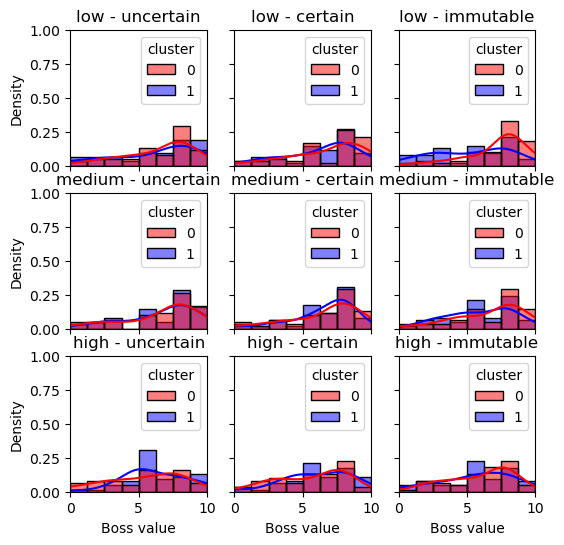

In [113]:
# Plot distribution of each cluster for each pair of certianty and trust
trusts = [
    'low',
    'medium',
    'high'
]

n_trusts = len(trusts)

certainties = [
    'uncertain',
    'certain',
    'immutable'
]

n_certainties = len(certainties)

certainty_colors = {
    'uncertain': 'limegreen',
    'certain': 'gold',
    'immutable': 'orchid'
}

fig, ax = plt.subplots(n_trusts, n_certainties, figsize=(2*n_trusts, 2*n_certainties), sharex=True, sharey=True)

for i, trust in enumerate(trusts):
    for j, certainty in enumerate(certainties):
        # Get the data for the trust and certainty
        df_plot = df_strats_out[(df_strats_out['trust'] == trust) & (df_strats_out['certainty'] == certainty)]
        # Plot the data
        sns.histplot(data=df_plot, x='trust_value', hue='cluster', ax=ax[i, j], kde=True, stat='density', common_norm=False, palette=['#FF0000', '#0000FF'])
        ax[i, j].set_title(f'{trust} - {certainty}')
        ax[i, j].set_xlabel('Boss value')
        ax[i, j].set_ylabel('Density')
        ax[i, j].set_xlim(0, 10)
        ax[i, j].set_ylim(0, 1)